## 金融风控项目
在此项目中，你需要完成金融风控模型的搭建。 基于一个用户的基本信息、历史信息来预测逾期与否。采样的具体数据是拍拍贷数据。https://www.kesci.com/home/competition/56cd5f02b89b5bd026cb39c9/content/1
在此数据中提供了三种不同类型的数据:
1. Master: 用户的主要信息
2. Loginfo: 登录信息
3. Userupdateinfo: 修改信息

在本次项目中，我们只使用```Master```的信息来预测一个用户是否会逾期。 数据里有一个字段叫作```Target```是样本的标签（label)。 在```Master```表格里，包含200多个特征，但不少特征具有缺失值。 做项目的时候需要仔细处理一下。 

对于特征处理方面的技术，请参考本章视频课程里的内容。

本项目区别于之前的项目，希望大家能够开放性地思考，不要太局限于给定的条条框框，把目前为止学到的知识都用起来。所以在项目的设计上区别于之前的，没有设置太多的框架性的，大家可以按照自己的思路灵活做项目。 由于项目本身来自于数据竞赛，所以可以试着跟竞赛里的TOP选手的结果做一下对比，看看跟他们的差距或者优势在哪儿。

```数据```
- ```Training/PPD_Training_Master_GBK_3_1_Training_Set.csv```:  训练数据
- ```Test/PPD_Master_GBK_2_Test_Set.csv```: 测试数据


强调：一定要把注释写清楚。 每个函数，每一个模块具体做什么写清楚。

> 注意： 除了下面导入的库，还有sklearn、XGBoost等经典的库之外，建议不要使用其他的函数库。 如果你不得不使用一些其他特殊的库，请把环境注明在requirements.txt里面，不然我们判作业的时候就没有办法去评判了。 

In [1]:
import numpy as np 
import math 
import pandas as pd 
pd.set_option('display.float_format',lambda x:'%.3f' % x)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import os 


In [2]:
# 读取Master数据
data = pd.read_csv('data/Training/PPD_Training_Master_GBK_3_1_Training_Set.csv',encoding='gb18030')
print (data.shape)

(30000, 228)


## 0 数据基本情况
了解一下数据的基本构成，样本的基本对比等。

In [3]:
# 展示记录
#data.iloc[:,:14].head()
data.head()

Idx  UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_1  \
0  10001       1.000         深圳       4.000         深圳           nan   
1  10002       1.000         温州       4.000         温州           nan   
2  10003       1.000         宜昌       3.000         宜昌           nan   
3  10006       4.000         南平       1.000         南平           nan   
4  10007       5.000         辽阳       1.000         辽阳           nan   

   WeblogInfo_2  WeblogInfo_3  WeblogInfo_4  WeblogInfo_5  ...  \
0         1.000           nan         1.000         1.000  ...   
1         0.000           nan         1.000         1.000  ...   
2         0.000           nan         2.000         2.000  ...   
3           nan           nan           nan           nan  ...   
4         0.000           nan         1.000         1.000  ...   

   SocialNetwork_10  SocialNetwork_11  SocialNetwork_12  SocialNetwork_13  \
0               222                -1                 0                 0   
1                 1                -1                 0                 0   
2                -1                -1                -1                 1   
3                -1                -1                -1                 0   
4                -1                -1                -1                 0   

   SocialNetwork_14  SocialNetwork_15  SocialNetwork_16  SocialNetwork_17  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 2   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   target  ListingInfo  
0       0     2014/3/5  
1       0    2014/2/26  
2       0    2014/2/28  
3       0    2014/2/25  
4       0    2014/2/27  

[5 rows x 228 columns]

In [4]:
# 正负样本的比例， 可以看出样本比例不平衡的，针对样本不平衡， 后面还要进行一些处理
data.target.value_counts()

0    27802
1     2198
Name: target, dtype: int64

Master  
每一行代表一个样本（一笔成功成交借款），每个样本包含200多个各类字段。

- idx：每一笔贷款的unique key，可以与另外2个文件里的idx相匹配。

- UserInfo_*：借款人特征字段

- WeblogInfo_*：Info网络行为字段

- Education_Info*：学历学籍字段

- ThirdParty_Info_PeriodN_*：第三方数据时间段N字段

- SocialNetwork_*：社交网络字段

- LinstingInfo：借款成交时间

- Target：违约标签（1 = 贷款违约，0 = 正常还款）。测试集里不包含target字段。

### 0.1 借款成交量的时间趋势变化

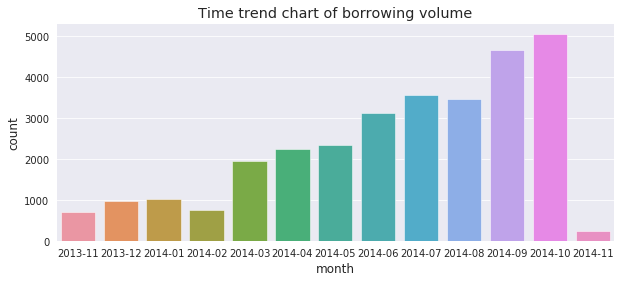

In [5]:
# 借款成交时间的范围
data.ListingInfo = pd.to_datetime(data.ListingInfo,errors='ignore')# 'coerce' format='%y%m%d',  infer_datetime_format=False,
# 格式转化2014-3-5 之后，可以用 dt 属性 直接调用时间属性

# 每个月份的用户数分布
data['month'] = data.ListingInfo.dt.strftime('%Y-%m')

# 绘制成交量的时间趋势图
plt.figure(figsize=(10,4))

#解决中文显示问题
#plt.rcParams['font.sans-serif']=['Microsoft YaHei']
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

#plt.title("借款成交量的时间趋势图")
plt.title('Time trend chart of borrowing volume')

sns.countplot(data=data.sort_values('month'),x='month')
plt.show()

### 0.2 违约情况的时间趋势分析

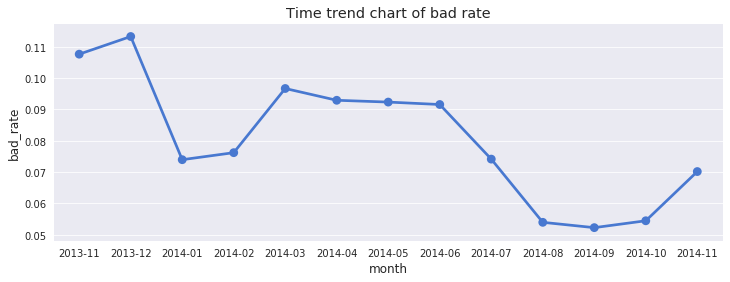

In [6]:
month_group = data.groupby('month') # 根据月份计算每个月的违约率
# groupby 分组以 month 作为index，
time_bad_trend = pd.DataFrame()
time_bad_trend['total'] = month_group.target.count()
time_bad_trend['bad'] = month_group.target.sum()
time_bad_trend['bad_rate']=time_bad_trend['bad']/time_bad_trend['total']
time_bad_trend = time_bad_trend.reset_index()

plt.figure(figsize=(12,4))
#plt.title('违约率的时间趋势图')
plt.title('Time trend chart of bad rate')
sns.pointplot(data=time_bad_trend,x='month',y='bad_rate',linestyles='-')
plt.show()

大致给一下思路，然后可以按照这个思路去一步步完成。 

> #### 1. 数据的预处。 需要考虑以下几个方面：
- ```缺失值```。数据里有大量的缺失值，需要做一些处理。 
- ```字符串的清洗```。比如“北京市”和“北京”合并成“北京”， 统一转换成小写等
- ```二值化```。
- ```衍生特征```：比如户籍地和当前城市是否是同一个？ 
- ```特征的独热编码```：对于类别型特征使用独热编码形式
- ```连续性特征的处理```：根据情况来处理
- ```其他```: 根据情况，自行决定要不要做

## 1 数据清洗 

### 1.1 缺失值处理
- 删除数据缺失比例很大的列，比如超过20%为nan  
- 删除数据缺失比例大的行，并保持删除的行数不超过总体的1%  
- 填补剩余缺失值，通过value_count观察是连续/离散变量，然后用最高频/平均数填补nan。这里通过观察，而不是判断类型是否object，更贴近实际情况

In [7]:
# 查看 某一个特征的总数是否等于 样本的总数
# 如果是则 丢弃 这个特征，显然这样的特征是无用的

for i in data.columns:
    if len(data[i].unique()) == len(data):
        data.drop(i,axis=1,inplace=True)
    else:
        pass
print(data.columns)
# drop idx

Index(['UserInfo_1', 'UserInfo_2', 'UserInfo_3', 'UserInfo_4', 'WeblogInfo_1',
       'WeblogInfo_2', 'WeblogInfo_3', 'WeblogInfo_4', 'WeblogInfo_5',
       'WeblogInfo_6',
       ...
       'SocialNetwork_11', 'SocialNetwork_12', 'SocialNetwork_13',
       'SocialNetwork_14', 'SocialNetwork_15', 'SocialNetwork_16',
       'SocialNetwork_17', 'target', 'ListingInfo', 'month'],
      dtype='object', length=228)


In [8]:
## 删除数据缺失比例超过一定比例的 特征
null_sum = data.isnull().sum() ## 每个特征 缺失值统计
null_sum = null_sum[null_sum!=0]
null_sum_df = pd.DataFrame(null_sum, columns=['num'])
null_sum_df['ratio'] = null_sum_df['num'] / 30000.0
null_sum_df.sort_values(by='ratio', ascending=False, inplace=True)# 降序排列
# null_sum_df.head()
# 删除缺失严重的列
data.drop(['WeblogInfo_3', 'WeblogInfo_1', 'UserInfo_11', 'UserInfo_13', 'UserInfo_12', 'WeblogInfo_20'],
                  axis=1, inplace=True)
data.head()
# 目前还剩221-1个特征 1个label

UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_2  WeblogInfo_4  \
0       1.000         深圳       4.000         深圳         1.000         1.000   
1       1.000         温州       4.000         温州         0.000         1.000   
2       1.000         宜昌       3.000         宜昌         0.000         2.000   
3       4.000         南平       1.000         南平           nan           nan   
4       5.000         辽阳       1.000         辽阳         0.000         1.000   

   WeblogInfo_5  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  ...  \
0         1.000         1.000            14             0  ...   
1         1.000         1.000            14             0  ...   
2         2.000         2.000             9             3  ...   
3           nan           nan             2             0  ...   
4         1.000         1.000             3             0  ...   

   SocialNetwork_11  SocialNetwork_12  SocialNetwork_13  SocialNetwork_14  \
0                -1                 0                 0                 0   
1                -1                 0                 0                 0   
2                -1                -1                 1                 0   
3                -1                -1                 0                 0   
4                -1                -1                 0                 0   

   SocialNetwork_15  SocialNetwork_16  SocialNetwork_17  target  ListingInfo  \
0                 0                 0                 1       0   2014-03-05   
1                 0                 0                 2       0   2014-02-26   
2                 0                 0                 0       0   2014-02-28   
3                 0                 0                 0       0   2014-02-25   
4                 0                 0                 0       0   2014-02-27   

     month  
0  2014-03  
1  2014-02  
2  2014-02  
3  2014-02  
4  2014-02  

[5 rows x 222 columns]

In [9]:
# 删除缺失严重的行
record_nan = data.isnull().sum(axis=1).sort_values(ascending=False)
drop_record_index = [i for i in record_nan.loc[(record_nan>=5)].index]
print('before train_master shape {}'.format(data.shape))
data.drop(drop_record_index, inplace=True)
print('after train_master shape {}'.format(data.shape))

before train_master shape (30000, 222)
after train_master shape (29189, 222)


In [10]:
# 填补缺失值
print('before all nan num: {}'.format(data.isnull().sum().sum())) # 计算缺失值 总数

data.loc[data['UserInfo_2'].isnull(), 'UserInfo_2'] = '未知地点'
data.loc[data['UserInfo_4'].isnull(), 'UserInfo_4'] = '未知地点'
# print(data.loc[data['UserInfo_2'].isnull(), 'UserInfo_2'])
def fill_nan(f, method):
    if method == 'most':
        common_value = pd.value_counts(data[f], ascending=False).index[0]
    else:
        common_value = data[f].mean()
    data.loc[data[f].isnull(), f] = common_value

# 还得判断一个特征其值是 连续 还是 离散的
# 通过pd.value_counts(data[f])的观察得到经验
fill_nan('UserInfo_1', 'most') # 高频数 填补
fill_nan('UserInfo_3', 'most')
fill_nan('WeblogInfo_2', 'most')
fill_nan('WeblogInfo_4', 'mean')
fill_nan('WeblogInfo_5', 'mean')
fill_nan('WeblogInfo_6', 'mean')
fill_nan('WeblogInfo_19', 'most')
fill_nan('WeblogInfo_21', 'most')

print('after all nan num: {}'.format(data.isnull().sum().sum()))

before all nan num: 9808
after all nan num: 0


### 1.2 字符串的清洗
- 比如“北京市”和“北京”合并成“北京”
- 统一转换成小写等  

城市： 'UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20'(貌似全含有市)  
省： 'UserInfo_7',UserInfo_19  
通讯运营商：UserInfo_9(中国移动、中国联通、不详...)  
婚姻： UserInfo_22  
······

In [11]:
# 城市特征清洗

# 计算4个城市特征的非重复项计数，观察是否有数据异常
for col in ['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']:
    print('{}:{}'.format(col,data[col].nunique())) # 注意 nunique() 和 unique() 的区别
    print('\t')

# UserInfo_8相对其他特征nunique较大，
# data.UserInfo_2.unique()
# data.UserInfo_4.unique()
#print(data.UserInfo_8.unique()[:50])
# UserInfo_8 发现有些城市有"市"，有些没有，需要做一下格式转换，去掉字符串后缀"市".

# UserInfo_8清洗处理，处理后非重复项计数减小到400
data['UserInfo_2']=[s[:-1] if s.find('市')>0 else s[:] for s in data.UserInfo_2] 
data['UserInfo_4']=[s[:-1] if s.find('市')>0 else s[:] for s in data.UserInfo_4] 
data['UserInfo_8']=[s[:-1] if s.find('市')>0 else s[:] for s in data.UserInfo_8] 
data['UserInfo_20']=[s[:-1] if s.find('市')>0 else s[:] for s in data.UserInfo_20] 

print("After")
for col in ['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']:
    print('{}:{}'.format(col,data[col].nunique())) # 注意 nunique() 和 unique() 的区别
    print('\t')

UserInfo_2:328
	
UserInfo_4:331
	
UserInfo_8:655
	
UserInfo_20:297
	
After
UserInfo_2:328
	
UserInfo_4:331
	
UserInfo_8:395
	
UserInfo_20:297
	


In [12]:
# 大小写统一
#'UserupdateInfo1'包含了大小写，如"qQ"和"QQ",属于同一种意思，所以需要对其英文字符统一转换大小写。

# 将UserupdateInfo1里的字符改为小写形式
# df2['UserupdateInfo1'] = df2.UserupdateInfo1.map(lambda x:x.lower())

## 2 特征处理

- ```二值化```。
- ```衍生特征```：比如户籍地和当前城市是否是同一个？ 
- ```特征的独热编码```：对于类别型特征使用独热编码形式
- ```连续性特征的处理```：根据情况来处理
- ```其他```: 根据情况，自行决定要不要做

### 2.1 二值化 one-hot
- 运营商处理。 string对齐，然后one-hot  
- 微博处理。 

In [13]:
# 运营商 处理

# data.UserInfo_9[0:21]
# 经检测发现 存在许多 空格不对齐的现象，导致类别增多
data['UserInfo_9'] = data['UserInfo_9'].str.strip()

# 因运营商的种类少，直接做亚编码处理即可。
# 将运营商信息转换为哑变量
data = data.replace({'UserInfo_9':{'中国移动':'china_mobile',
                                     '中国电信':'china_telecom',
                                     '中国联通':'china_unicom',
                                     '不详':'operator_unknown'}})

oper_dummy = pd.get_dummies(data.UserInfo_9)
data = pd.concat([data,oper_dummy],axis=1)
# 删除原变量
data = data.drop(['UserInfo_9'],axis=1)
# 变成了data.china_mobile, data.china_telecom


## data.UserInfo_9 = pd.get_dummies(data.UserInfo_9)

In [14]:
# 微博数据处理

# 前面已经做过 缺失值填充
# 先进行webo数据观察
# data.WeblogInfo_19.value_counts()
# data.WeblogInfo_21.value_counts()

# 微博变量的哑变量处理
data['WeblogInfo_19'] = ['WeblogInfo_19_'+s for s in data.WeblogInfo_19]
data['WeblogInfo_21'] = ['WeblogInfo_21_'+s for s in data.WeblogInfo_21]

for col in ['WeblogInfo_19','WeblogInfo_21']:
    dummy_df = pd.get_dummies(data[col])
    data = pd.concat([data,dummy_df],axis=1)
# 删除原变量
data = data.drop(['WeblogInfo_19','WeblogInfo_21'],axis=1)

In [15]:
temp1 = pd.to_datetime(data.ListingInfo,errors='ignore')# 'coerce' format='%y%m%d',  infer_datetime_format=False,
temp = temp1.dt.day + temp1.dt.month
temp.head()

0     8
1    28
2    30
3    27
4    29
Name: ListingInfo, dtype: int64

### 2.2 特征分类

- 剩余的feature中，根据dtype，把所有features分为numerical和categorical 2类.
- numerical中，如果unique num不超过10个，也归属为categorical分类

**<M8[ns],datetime64[ns]** 二者的区别在于，datetime64[ns] 是通用型数据类型，而 <M8[ns] 则属于特定型的数据类型（与物理机器有关，具体取决于大顶端和小顶端）

In [16]:
# 特征分类， 根据dtype，把所有features分为numerical和categorical 2类

categorical_features = [f for f in data.select_dtypes(include = ["object"]).columns 
                        if f not in(['ListingInfo', 'target'])]
                    #  and f not in binarized_features
#                         and 'ThirdParty_Info_Period' not in f]

numerical_features = [f for f in data.select_dtypes(exclude = ['object']).columns 
                      if f not in(['ListingInfo','target'])] # 'Idx' 已经 drop
                     #  and f not in binarized_features
#                       and 'ThirdParty_Info_Period' not in f]


In [17]:
# numerical中，如果unique num不超过10个，也归属为categorical分类

feature_unique_count = []
for f in numerical_features:
    feature_unique_count.append((np.count_nonzero(data[f].unique()), f))
    
#print(sorted(feature_unique_count))

for c,f in feature_unique_count:
    if c <= 10:
        print('{} moved from numerical to categorical'.format(f))
        numerical_features.remove(f)
        categorical_features.append(f)

UserInfo_1 moved from numerical to categorical
UserInfo_3 moved from numerical to categorical
WeblogInfo_2 moved from numerical to categorical
WeblogInfo_10 moved from numerical to categorical
WeblogInfo_11 moved from numerical to categorical
WeblogInfo_13 moved from numerical to categorical
UserInfo_5 moved from numerical to categorical
UserInfo_6 moved from numerical to categorical
UserInfo_10 moved from numerical to categorical
UserInfo_14 moved from numerical to categorical
UserInfo_15 moved from numerical to categorical
UserInfo_16 moved from numerical to categorical
UserInfo_17 moved from numerical to categorical
UserInfo_21 moved from numerical to categorical
Education_Info1 moved from numerical to categorical
Education_Info5 moved from numerical to categorical
WeblogInfo_23 moved from numerical to categorical
WeblogInfo_25 moved from numerical to categorical
WeblogInfo_26 moved from numerical to categorical
WeblogInfo_28 moved from numerical to categorical
WeblogInfo_29 moved f

### 2.3 异常值(outlier)处理
outlier删除
- 所有的numerical feature，画出在不同target下的分布图，stripplot(with jitter)，类似于boxplot，不过更方便于大值outlier寻找。

使用箱线图、stripplot等来辅助观察outlier。 

- 寻找所有的numerical feature，画出在不同target下的分布图，stripplot(with jitter)，类似于boxplot，不过更方便于大值outlier寻找。

```python
melt = pd.melt(train_master, id_vars=['target'], value_vars = [f for f in numerical_features])
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.stripplot, 'target', 'value', jitter=True, palette="muted")
```

- 绘制所有numerical features的密度图，并且可以观察出，它们都可以通过求对数转化为更接近正态分布   

```python3
for f in numerical_features_log:
    train_master[f + '_log'] = np.log1p(train_master[f])
```

转化为log分布后，可以再删除一些极小的outlier。  

Reference:  
[seaborn可视化学习之category visualization](https://zhuanlan.zhihu.com/p/29559042)  

**Numerical**

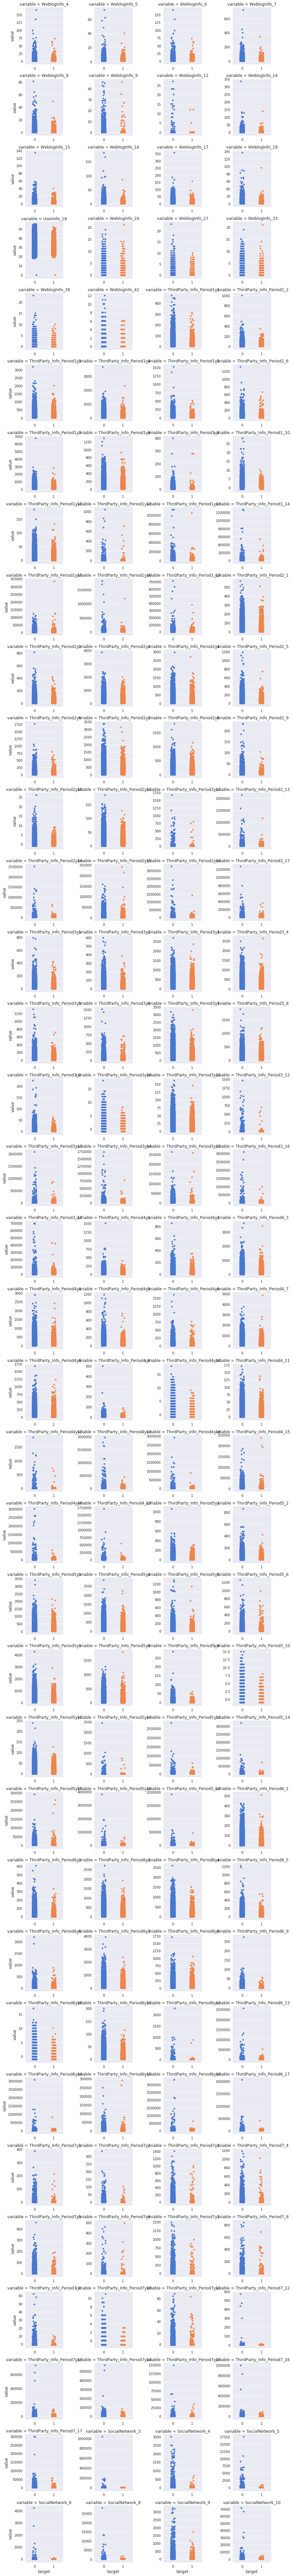

In [18]:
melt = pd.melt(data, id_vars=['target'], value_vars = [f for f in numerical_features])
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.stripplot, 'target', 'value', jitter=True, palette="muted")

In [19]:
# hard work, but helps a lot
# 根据上面的图像，来drop一些异常值。 比较麻烦一步一步，一张一张图来

print('{} lines before drop'.format(data.shape[0]))

data.drop(data[(data.ThirdParty_Info_Period6_1 > 250) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period6_2 > 400].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_2 > 250) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period6_3 > 2000].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_3 > 1250) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period6_4 > 1500].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_4 > 1250) & (data.target == 1)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_5 > 400)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_7 > 2000)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_6 > 1500)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_5 > 1000) & (data.target == 0)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_8 > 1500)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_8 > 1000) & (data.target == 1)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_16 > 2000000) & (data.target == 0)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_14 > 1000000) & (data.target == 0)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_12 > 60)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_11 > 120) & (data.target == 0)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_11 > 20) & (data.target == 1)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_13 > 200000)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_13 > 150000) & (data.target == 1)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_15 > 40000) & (data.target == 1)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period6_17 > 130000) & (data.target == 0)].index, inplace=True)


data.drop(data[data.ThirdParty_Info_Period5_1 > 500].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_2 > 500].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period5_3 > 3000) & (data.target == 0)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period5_3 > 2000)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_5 > 500].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period5_4 > 2000) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_6 > 700].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period5_6 > 300) & (data.target == 1)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period5_7 > 4000)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period5_8 > 800)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period5_11 > 200)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_13 > 200000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_14 > 150000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_15 > 75000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_16 > 180000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period5_17 > 150000].index, inplace=True)

# go above

data.drop(data[(data.ThirdParty_Info_Period4_1 > 400)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period4_2 > 350)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period4_3 > 1500)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_4 > 1600].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period4_4 > 1250) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_5 > 500].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_6 > 800].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period4_6 > 400) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_8 > 1000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_13 > 250000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_14 > 200000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_15 > 70000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_16 > 210000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period4_17 > 160000].index, inplace=True)


data.drop(data[data.ThirdParty_Info_Period3_1 > 400].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_2 > 380].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_3 > 1750].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_4 > 1750].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period3_4 > 1250) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_5 > 600].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_6 > 800].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period3_6 > 400) & (data.target == 1)].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period3_7 > 1600) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_8 > 1000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_13 > 300000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_14 > 200000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_15 > 80000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_16 > 300000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period3_17 > 150000].index, inplace=True)


data.drop(data[data.ThirdParty_Info_Period2_1 > 400].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period2_1 > 300) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_2 > 400].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period2_2 > 300) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_3 > 1800].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period2_3 > 1500) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_4 > 1500].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_5 > 580].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_6 > 800].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period2_6 > 400) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_7 > 2100].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period2_8 > 700) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_11 > 120].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_13 > 300000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_14 > 170000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_15 > 80000].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period2_15 > 50000) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_16 > 300000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period2_17 > 150000].index, inplace=True)


data.drop(data[data.ThirdParty_Info_Period1_1 > 350].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_1 > 200) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_2 > 300].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_2 > 190) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_3 > 1500].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_4 > 1250].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_5 > 400].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_6 > 500].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_6 > 250) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_7 > 1800].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_8 > 720].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_8 > 600) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_11 > 100].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_13 > 200000].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_13 > 140000) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_14 > 150000].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_15 > 70000].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_15 > 30000) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_16 > 200000].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_16 > 100000) & (data.target == 1)].index, inplace=True)
data.drop(data[data.ThirdParty_Info_Period1_17 > 100000].index, inplace=True)
data.drop(data[(data.ThirdParty_Info_Period1_17 > 80000) & (data.target == 1)].index, inplace=True)

data.drop(data[data.WeblogInfo_4 > 40].index, inplace=True)
data.drop(data[data.WeblogInfo_6 > 40].index, inplace=True)
data.drop(data[data.WeblogInfo_7 > 150].index, inplace=True)
data.drop(data[data.WeblogInfo_16 > 50].index, inplace=True)
data.drop(data[(data.WeblogInfo_16 > 25) & (data.target == 1)].index, inplace=True)
data.drop(data[data.WeblogInfo_17 > 100].index, inplace=True)
data.drop(data[(data.WeblogInfo_17 > 80) & (data.target == 1)].index, inplace=True)
data.drop(data[data.UserInfo_18 < 10].index, inplace=True)

print('{} lines after drop'.format(data.shape[0]))

29189 lines before drop
28074 lines after drop


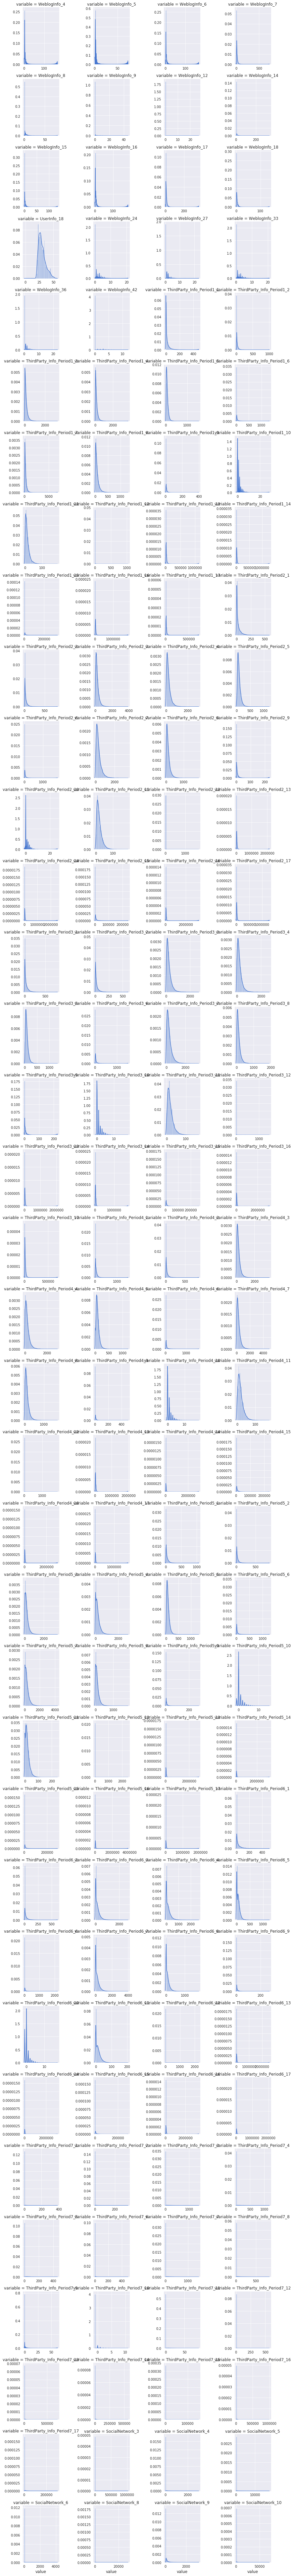

In [20]:
# 直方图hist +  内核密度函数

# melt = pd.melt(data, id_vars=['target'], value_vars = [f for f in numerical_features if f != 'Idx'])
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

In [21]:
# 一些数据差异过大，进行取对数处理
numerical_features_log = [f for f in numerical_features if f not in ['Idx']]

for f in numerical_features_log:
    data[f + '_log'] = np.log1p(data[f])
    data.drop([f], axis=1, inplace=True)


In [22]:
from math import inf

(data == -inf).sum().sum()

854357

In [23]:
data.replace(-inf, -1, inplace=True)

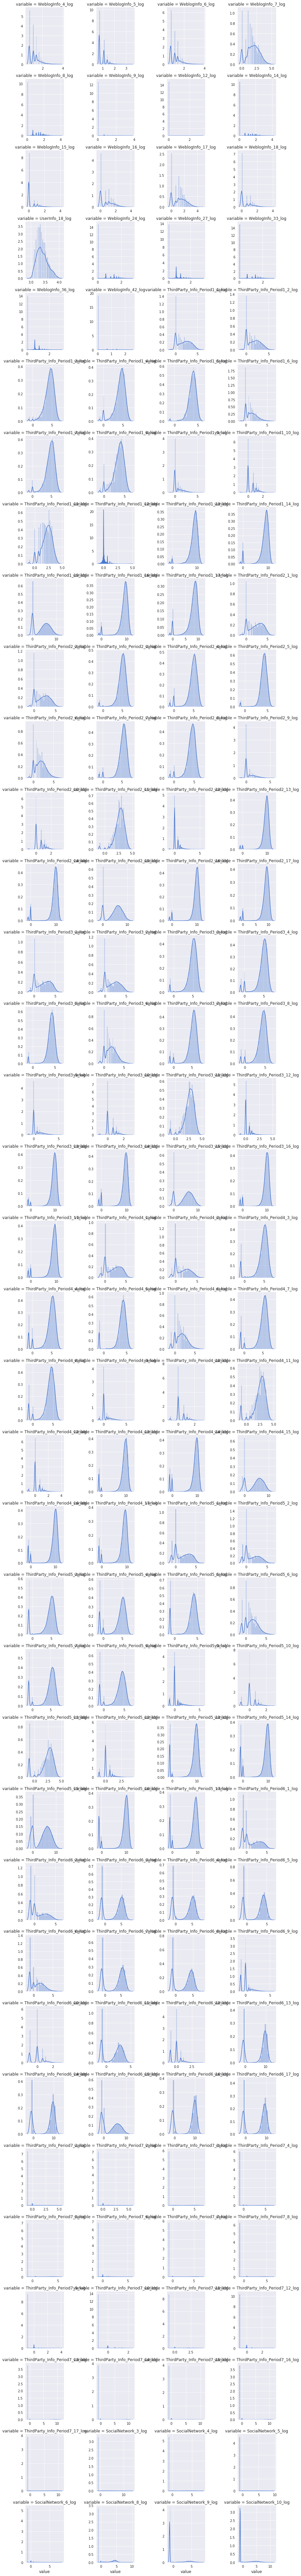

In [24]:
# log后的密度图，应该分布靠近正态分布了
melt = pd.melt(data, id_vars=['target'], value_vars = [f+'_log' for f in numerical_features])
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

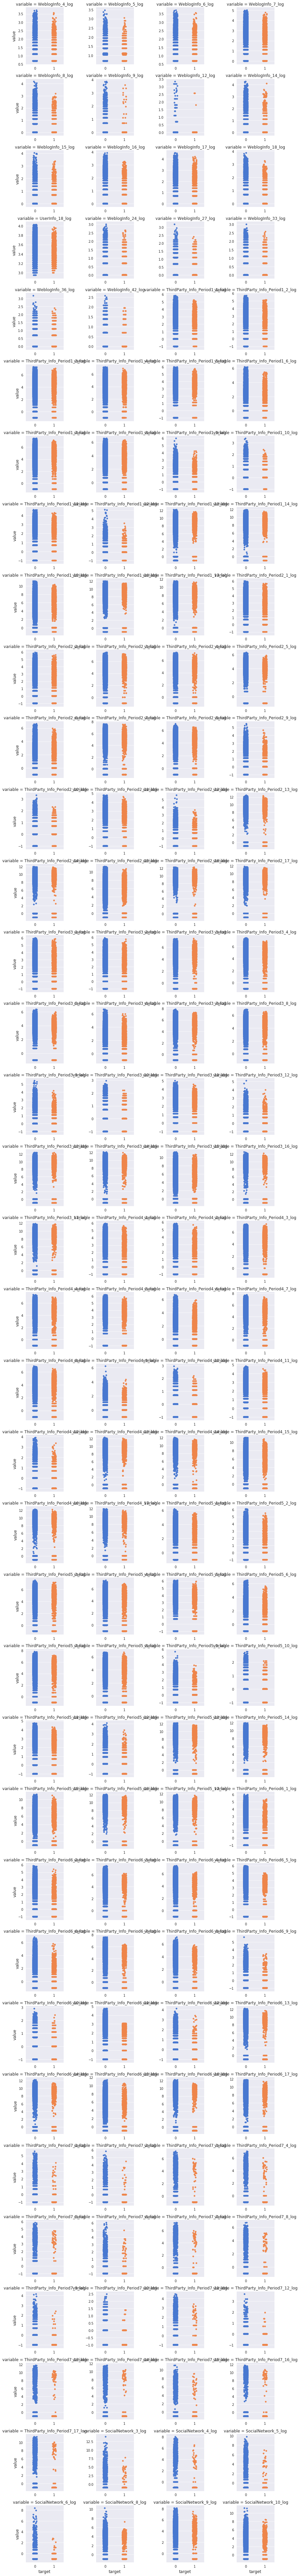

In [25]:
# log后的分布图，看是否有log后的outlier
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.stripplot, 'target', 'value', jitter=True, palette="muted")

**categorical**    
如果想知道在每个类别下面有多少个观察值，用**countplot**就可以，相当于是做一个observation

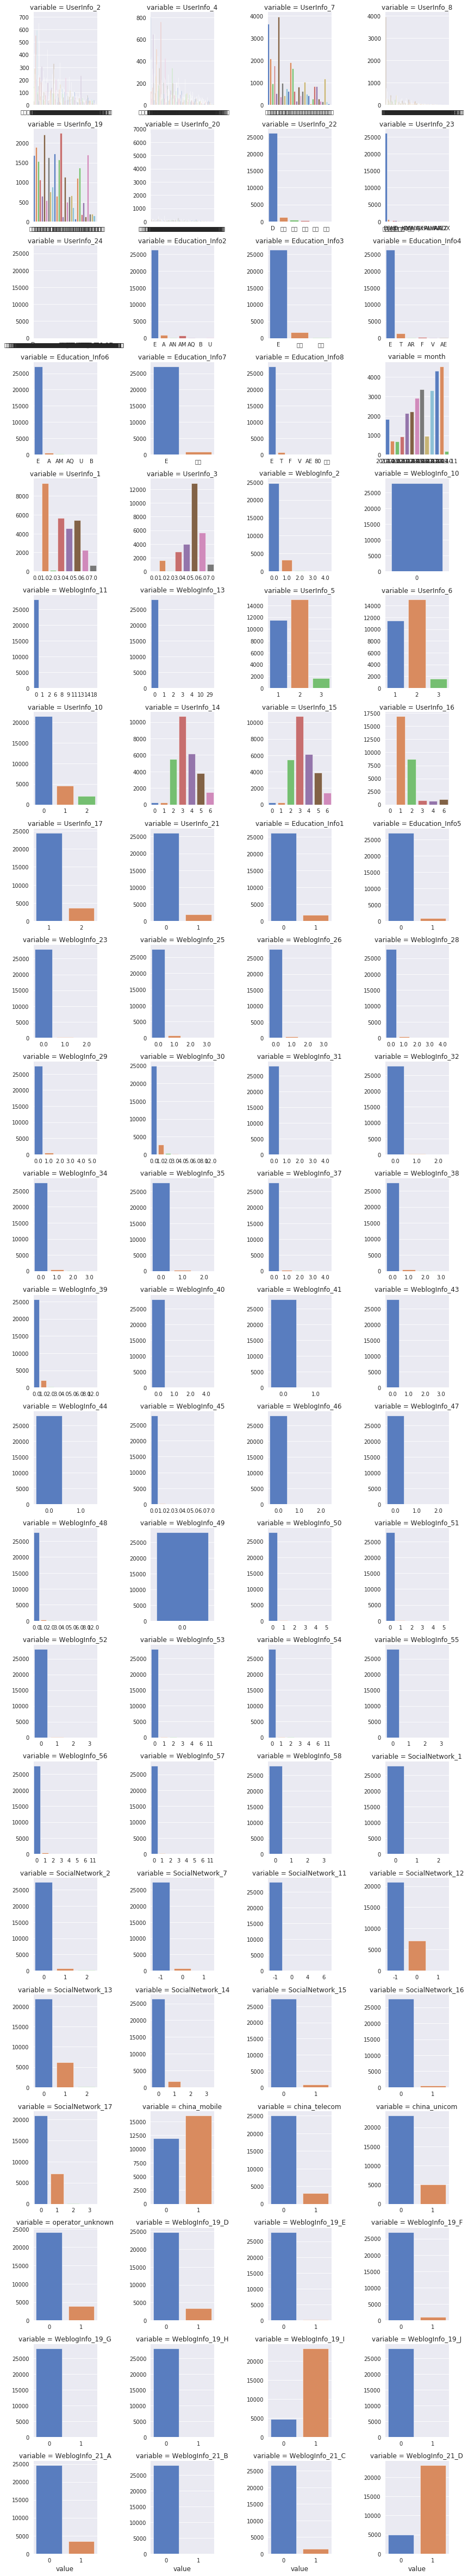

In [26]:
# 显示 每个类别下面有多少个观察值
# melt:“Unpivots” a DataFrame from wide format to long format, optionally leaving identifier variables set.
melt = pd.melt(data, id_vars=['target'], value_vars=[f for f in categorical_features])
g = sns.FacetGrid(melt, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.countplot, 'value', palette="muted")

### 2.4 相关性查看


In [27]:
target_corr = np.abs(data.corr()['target']).sort_values(ascending=False)# Compute pairwise correlation
target_corr

target                           1.000
ThirdParty_Info_Period6_5_log    0.140
ThirdParty_Info_Period6_11_log   0.139
ThirdParty_Info_Period6_4_log    0.138
ThirdParty_Info_Period6_7_log    0.136
                                  ... 
WeblogInfo_38                    0.001
WeblogInfo_23                    0.000
ThirdParty_Info_Period1_8_log    0.000
WeblogInfo_10                      nan
WeblogInfo_49                      nan
Name: target, Length: 217, dtype: float64

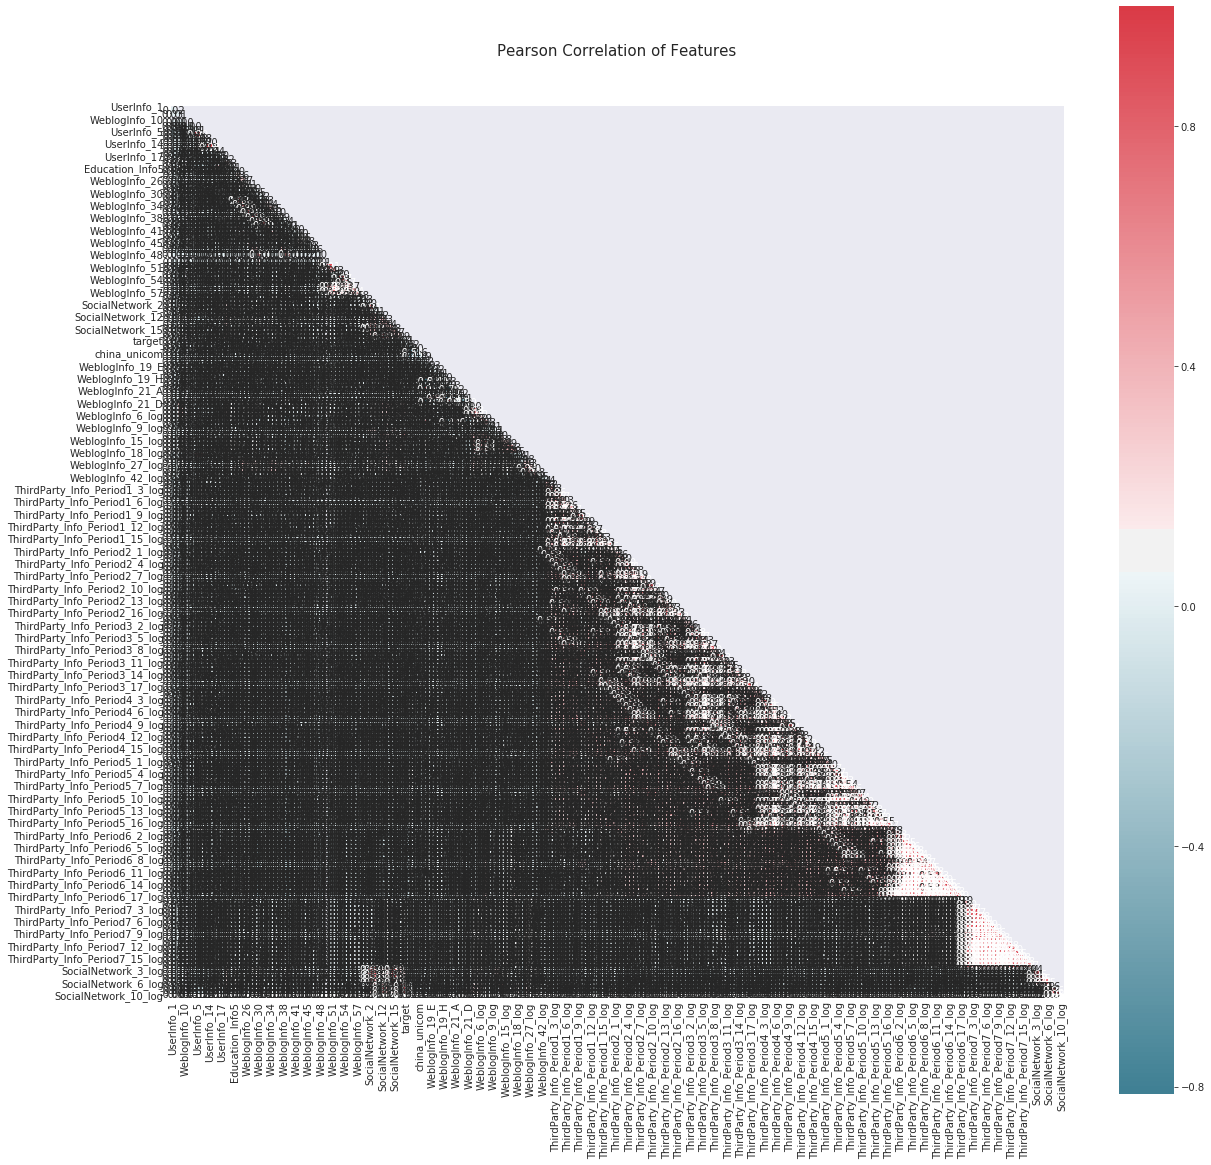

In [28]:
# 查看各个特征之间的相关性， 计算pearson(皮尔森)系数, 并用 heatmap 来显示
# heatmap(热力图)一般用来描述 feature 的相关性矩阵
#colormap = plt.cm.viridis
corr = data.corr() # pearson correlation
#mask =   
plt.figure(figsize=(20,20))  # 根据需要自行设置大小（也可省略）
plt.title('Pearson Correlation of Features', y=1.05, size=15) # 加标题
#sns.set() #重置参数
mask = np.zeros_like(corr)  # 利用mask只显示一半
mask[np.triu_indices_from(mask)] = True  # np.triu_indices_from 消去矩阵的上半部分  np.tril_indices_from 消去矩阵的下半部分
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象
# with sns.axes_style("white"):
#     ax = sns.heatmap(corr, mask=mask,annot=True, square=True, fmt='0.2f') # annot显示相应的值; fmt format value显示保留
    
ax = sns.heatmap(corr, mask=mask,annot=True, cmap=cmap, square=True, fmt='0.2f') # annot显示相应的值; fmt format value显示保留

# 特征数量太多，考虑取消这一步

### 2.5 衍生特征
- 排序特征衍生  
- periods特征衍生  
- 地域特征衍生。 户籍所在地 居住所在地  
- $\cdots$



In [29]:
#data['at_home'] = np.where(data['UserInfo_2']==data['UserInfo_8'], 1, 0)

### 2.6 日期处理

In [30]:
#data_ = data.copy()

In [31]:
# def parse_ListingInfo(date):
#     d = parse_date(date, 'YYYY/M/D')
#     return Series(d, 
#                   index=['ListingInfo_timestamp', 'ListingInfo_year', 'ListingInfo_month',
#                            'ListingInfo_day', 'ListingInfo_week', 'ListingInfo_isoweekday', 'ListingInfo_month_stage'], 
#                   dtype=np.int32)

# ListingInfo_parsed = data_['ListingInfo'].apply(parse_ListingInfo)
# print('before data_ shape {}'.format(data_.shape))
# data_ = data_.merge(ListingInfo_parsed, how='left', left_index=True, right_index=True)
# print('after data_ shape {}'.format(data_.shape))

In [32]:
# ## 对数值型特征按数值从小到大进行排序，衍生成排序特征，排序特征异常值有更强的鲁棒性，可以增强模型的稳定性，降低过拟合风险。

# num_col2 = [col for col in num_col if col!='target']
# # 筛选出只有数值型变量的数据集
# num_data = data1.loc[:,num_col2]

# # 排序特征衍生
# for col in num_col2:
#     num_data['rank'+col] = num_data[col].rank(method='max')/num_data.shape[0]

# # 将排序特征转为单独的数据集
# rank_col = [col for col in num_data.columns if col not in num_col2]
# rank_df = num_data.loc[:,rank_col]

In [33]:
# # 生成只包含periods的临时表
# periods_col = [i for i in num_col2 if i.find('Period')>0]
# periods_col2 = periods_col+['target']
# periods_data = data1.loc[:,periods_col2]


In [34]:
# 到此 仍然 还有很多特征,有一定效果，继续提高

> #### 2. 特征选择
200多个特征里可能有效的特征不会很多。在这里做特征选择相关的工作。 在特征选择这一块请使用```树```模型。 比如sklearn自带的特征选择模块（https://scikit-learn.org/stable/modules/feature_selection.html）， 或者直接使用XGBoost等模型来直接选择。 这些模型训练好之后你可以直接通过```feature_importance_values```属性来获取。

In [36]:
data.shape

(28074, 234)

> #### 3. XGBoost来训练风控模型，结果以AUC为准
https://github.com/dmlc/xgboost   这是XGBoost library具体的地址, 具有详细的文档。 https://pypi.org/project/xgboost/ 里有安装的步骤。 试着去调一下它的超参数，使得得到最好的效果。 一定要注意不需要使用测试数据来训练。 最终的结果以测试数据上的AUC为标准。 

In [56]:
data_test = pd.read_csv('data/Test/PPD_Master_GBK_2_Test_Set.csv',encoding='gb18030')
train_X = data.drop(['target'],axis=1)
train_y = data.target

In [58]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid = train_test_split(train_X,train_y,test_size=0.2,random_state=2000)
# print("The shape of train_X is ",X_train.shape,"The shape of valid_X is ",X_valid.shape)

The shape of train_X is  (17967, 233) The shape of valid_X is  (4492, 233)


In [70]:
n_fold = 5
kfold = StratifiedKFold(n_splits=n_fold, shuffle=False, random_state=1314)
for i, (train_index, valid_index) in enumerate(kfold.split(train_X, train_y)):
    print("The {}_th fold".format(i))
    X_train, X_valid = train_X.loc[train_index], train_X.loc[valid_index] # dataFrame 需要使用 .loc()
    y_train, y_valid = train_y.loc[train_index], train_y.loc[valid_index]
print(X_train.shape,X_valid.shape)

The 0_th fold
The 1_th fold
The 2_th fold
The 3_th fold
The 4_th fold
(17968, 233) (4491, 233)


In [73]:
# no_feas=['Idx','target']
# features=[fea for fea in data.columns if fea not in no_feas]
# features[:10]

features = [fea for fea in train_X.columns]
len(features)

test_size = len(data_test)

In [82]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import xgboost as xgb
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
from sklearn.model_selection import StratifiedKFold, KFold 
# StratifiedKFold用法类似Kfold，但是他是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同。
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm # 进度条模块

n_fold = 5
y_scores = 0

y_test_pred=np.zeros(test_size) # 暂存5折测试集预测结果
fea_importances = np.zeros(len(features)) # 特征重要性

# label = ['target']
# train[label] = train[label].astype(int)


def pred(X_test, model, batch_size=10000):
    iterations = (X_test.shape[0] + batch_size - 1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(test_size)
    print(f'predicting {i}-th model')
    for k in tqdm(range(iterations)):
        y_pred_test = model.predict_proba(X_test[k * batch_size:(k + 1) * batch_size])[:, 1]
        y_test_pred_total[k * batch_size:(k + 1) * batch_size] += y_pred_test
    return y_test_pred_total


# [1314, 4590]
kfold = StratifiedKFold(n_splits=n_fold, shuffle=False, random_state=1314)
for i, (train_index, valid_index) in enumerate(kfold.split(train_X, train_y)):
    print("The {}_th fold".format(i))
    X_train, X_valid = train_X.loc[train_index], train_X.loc[valid_index] # dataFrame 需要使用 .loc()
    y_train, y_valid = train_y.loc[train_index], train_y.loc[valid_index]
    bst = xgb.XGBClassifier(learning_rate=0.1,
                            n_estimators=1000,
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective='binary:logistic',
                            nthread=20,
                            scale_pos_weight=1,
                            seed=2
                            )
    bst.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_valid, y_valid)],
            eval_metric=['logloss', 'auc'],
            verbose=True
            )# ,early_stopping_rounds=10
    valid_pred = bst.predict_proba(X_valid)[:, 1]
    # print("accuracy:",accuracy_score(y_valid, valid_pred))
    print("acu score:", roc_auc_score(y_valid, valid_pred))
    y_scores += bst.best_score
        
    # 预测结果
    y_test_pred+=bst.predict_proba(test[features])[:, 1]
    fea_importances += bst.feature_importances_
    del bst
    del valid_pred
    gc.collect()


fea_importance_df = pd.DataFrame({
    'features': features,
    'importance': fea_importances
})
fea_importance_df.sort_values(by="importance", ascending=False)



The 0_th fold


ValueError: y contains previously unseen labels: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
plt.figure(figsize=(14, 30))
sns.barplot(x="importance", y="features", data=fea_importance_df.sort_values(by="importance", ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.show()

Reference:  
GitHub https://github.com/wikke/ppdai_risk_evaluation  
[Kesci“魔镜杯”风控算法大赛铜奖解决方案](https://blog.csdn.net/Bryan__/article/details/51190452)  
知乎 [风控模型实战--"魔镜杯"风控算法大赛](https://zhuanlan.zhihu.com/p/56864235)  
bi站 [机器学习经典算法：Xgboost](https://www.bilibili.com/video/av50905316?p=4) 
推荐细读 [机器学习之 特征工程](https://juejin.im/post/5b569edff265da0f7b2f6c65)  
异常值处理：[机器学习基础与实践（一）----数据清洗](https://www.cnblogs.com/charlotte77/p/5606926.html)  
[xgboost的原理没你想像的那么难](https://www.jianshu.com/p/7467e616f227)  
[Python数据可视化, 看这一篇就够了](https://zhuanlan.zhihu.com/p/45237245)  